In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import pickle
from tqdm import tqdm
from sklearn.metrics import r2_score, accuracy_score

In [2]:
filename="ecg_2023-07-10_time.csv"
data = pd.read_csv('ecg_2023-07-10_time.csv', encoding='utf-8')
data.head(15)

,이름,최영우
0,생년월일,2001. 7. 5.
1,기록된 날짜,2024-03-15 17:32:19 +0900
2,분류,동리듬
3,증상,NaN
4,소프트웨어 버전,1.90
5,기기,"Watch6,6"
6,샘플률,512헤르츠
7,유도,유도 I
8,단위,µV
9,-27.677,23:18:38.000


In [3]:
import numpy as np

'''
def makeNumpyData(data):
    """ Pandas DataFrame의 '심박수_배열' 열을 NumPy 배열로 변환 
        - 0이거나 숫자가 아닌 값은 제외
    """
    ppg_data = data['심박수_배열']
    
    ppg_data_cleaned = []
    for row in ppg_data.astype(str):
        try:
            numbers = [
                int(num.strip()) 
                for num in row.split(",") 
                if num.strip().isdigit() and int(num.strip()) != 0
            ]
            ppg_data_cleaned.extend(numbers)
        except ValueError as e:
            print(f"변환 오류 발생: {row} - {e}")

    return np.array(ppg_data_cleaned, dtype=np.int32)
'''

def makeNumpyData(data):
    """ 
    9행부터의 첫 번째 열을 숫자로 변환하여 NumPy 배열로 반환하고, 
    두 번째 열에서 타임스탬프 문자열도 함께 반환
    - 0이거나 숫자가 아닌 값은 제외
    """
    heart_rate_values = data.iloc[9:, 0]  # 값
    timestamps = data.iloc[9:, 1]         # 시간
    cleaned_values = []
    cleaned_times = []

    for val, time in zip(heart_rate_values, timestamps):
        try:
            num = float(val)
            if num != 0:
                cleaned_values.append(num)
                cleaned_times.append(time)
        except ValueError:
            print(f"변환 오류: {val}")

    return np.array(cleaned_values, dtype=np.float32), list(cleaned_times)
    
def createSequence(data, seq_length):
    """ 시퀀스 데이터 및 레이블 생성 """
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])  # seq_length만큼 입력
        labels.append(data[i+seq_length])  # 다음 값이 레이블
    return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.float32)  # float으로 변환

def makeTensorData(X, y):
    """ 데이터를 스케일링 후 PyTorch Tensor로 변환 """
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X).astype(np.float32)  # (batch, seq_length)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).astype(np.float32)  # (batch, 1)

    # PyTorch Tensor 변환
    X_tensor = torch.tensor(X_scaled).unsqueeze(-1)  # (batch, seq_length, 1)
    y_tensor = torch.tensor(y_scaled).squeeze()  # (batch,)

    return X_tensor, y_tensor

def setTrainTestData(X_tensor, y_tensor, batch_size):
    """ 학습 및 테스트 데이터 분할 후 DataLoader 생성 """
    train_size = int(len(X_tensor) * 0.8)
    
    X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
    X_test, y_test = X_tensor[train_size:], y_tensor[train_size:]

    # DataLoader 적용
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("데이터 변환 완료! X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
    print("X_test.shape:", X_test.shape, "y_test.shape:", y_test.shape)
    
    return train_loader, test_loader, X_train, y_train, X_test, y_test

In [4]:
##수 정 할 변 수 들##
seq_length = 32 # Length of Sequence
batch_size = 16 # Literally Batch Size
num_epochs = 10 # How much time will model practice?
update_interval = 20  # tqdm 업데이트 주기 (매 10배치마다 갱신)
practice_num = 5 # set Pickle File Number (update +1 every time)

# main section
ecg_values, time_stamps = makeNumpyData(data)
print(ecg_values[:5]) 
print(time_stamps[:5]) 
X, y = createSequence(ecg_values, seq_length)
X_tensor, y_tensor = makeTensorData(X, y)
train_loader, test_loader, X_train, y_train, X_test, y_test = setTrainTestData(X_tensor, y_tensor, batch_size)

[ -27.677  -48.607  -68.768  -87.902 -105.799]
['23:18:38.000', '23:18:38.001', '23:18:38.003', '23:18:38.005', '23:18:38.007']
데이터 변환 완료! X_train.shape: torch.Size([12262, 32, 1]) y_train.shape: torch.Size([12262])
X_test.shape: torch.Size([3066, 32, 1]) y_test.shape: torch.Size([3066])


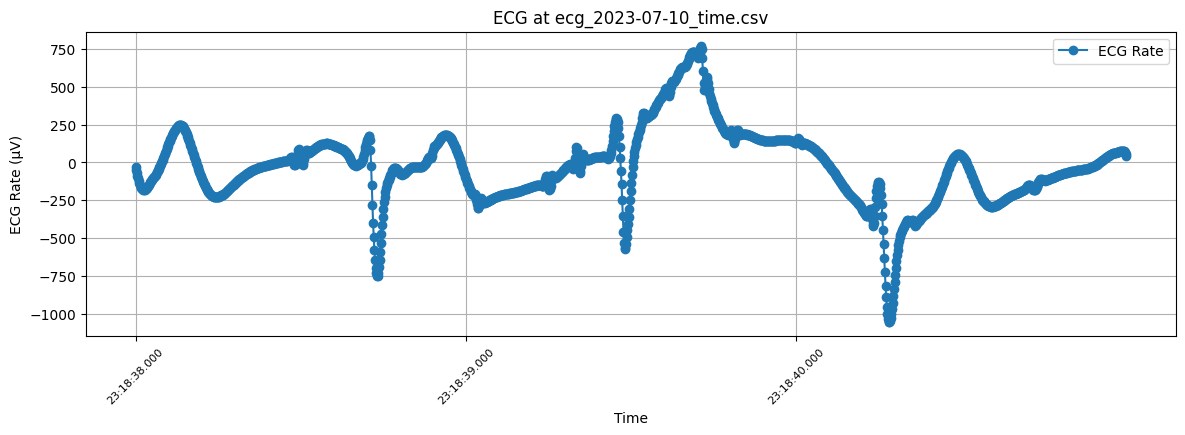

In [6]:
##데이터 시각화##

# 심박수 NumPy 배열 생성
subset_y = ecg_values[:1536]
subset_x = time_stamps[:1536]

# 그래프 시각화
plt.figure(figsize=(12, 4))
plt.plot(subset_x, subset_y, marker='o', linestyle='-', label='ECG Rate')
plt.title(f'ECG at {filename}')
plt.xlabel('Time')
plt.ylabel('ECG Rate (µV)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# 512회(1초)당 한번씩만 시간(x축) 출력
tick_spacing = 512
tick_positions = np.arange(0, len(subset_x), tick_spacing)
tick_labels = [subset_x[i] for i in tick_positions]

plt.xticks(tick_positions, tick_labels, rotation=45, fontsize=8)

plt.show()

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=3, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = torch.relu(out[:, -1, :])
        out = self.fc(out)
        return out


In [36]:
import torch
print(torch.version.cuda)  # CUDA 버전 출력
print(torch.cuda.is_available())  # CUDA 사용 가능 여부


11.8
True


In [37]:
# 모델, 손실 함수, 옵티마이저 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel().to(device)  # <- 여기를 먼저 실행
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 데이터도 GPU로 이동
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


LSTMModel(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델도 GPU로

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for i, (X_batch, y_batch) in enumerate(progress_bar):
        optimizer.zero_grad()

        # 데이터도 GPU로 이동
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(-1)  # 한 번만 unsqueeze!

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if i % update_interval == 0:
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    ##### 평가 #####
    model.eval()
    with torch.no_grad():
        y_true, y_pred_list = [], []

        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(-1)

            y_pred = model(X_batch)

            if isinstance(criterion, torch.nn.MSELoss):
                y_pred_list.extend(y_pred.cpu().numpy())
                y_true.extend(y_batch.cpu().numpy())
            else:
                y_pred_class = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
                y_pred_list.extend(y_pred_class.cpu().numpy())
                y_true.extend(y_batch.cpu().numpy())

        if isinstance(criterion, torch.nn.MSELoss):
            accuracy = r2_score(y_true, y_pred_list)
        else:
            accuracy = accuracy_score(y_true, y_pred_list)

    print(f"\nEpoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

##### 모델 저장 #####
model_path = f"LSTM_model{practice_num}.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model, f)
print(f"모델이 저장되었습니다: {model_path}")


Epoch 1/10: 100%|███████████████| 767/767 [00:01<00:00, 493.78it/s, loss=0.0008]



Epoch [1/10], Average Loss: 0.0298, Accuracy: 0.9134


Epoch 2/10: 100%|███████████████| 767/767 [00:01<00:00, 507.95it/s, loss=0.0003]



Epoch [2/10], Average Loss: 0.0017, Accuracy: 0.8847


Epoch 3/10: 100%|███████████████| 767/767 [00:01<00:00, 509.00it/s, loss=0.0006]



Epoch [3/10], Average Loss: 0.0013, Accuracy: 0.9383


Epoch 4/10: 100%|███████████████| 767/767 [00:01<00:00, 507.47it/s, loss=0.0001]



Epoch [4/10], Average Loss: 0.0010, Accuracy: 0.9615


Epoch 5/10: 100%|███████████████| 767/767 [00:01<00:00, 508.64it/s, loss=0.0014]



Epoch [5/10], Average Loss: 0.0009, Accuracy: 0.9469


Epoch 6/10: 100%|███████████████| 767/767 [00:01<00:00, 523.15it/s, loss=0.0007]



Epoch [6/10], Average Loss: 0.0007, Accuracy: 0.9540


Epoch 7/10: 100%|███████████████| 767/767 [00:01<00:00, 507.96it/s, loss=0.0007]



Epoch [7/10], Average Loss: 0.0007, Accuracy: 0.9760


Epoch 8/10: 100%|███████████████| 767/767 [00:01<00:00, 507.37it/s, loss=0.0004]



Epoch [8/10], Average Loss: 0.0006, Accuracy: 0.9611


Epoch 9/10: 100%|███████████████| 767/767 [00:01<00:00, 507.28it/s, loss=0.0002]



Epoch [9/10], Average Loss: 0.0006, Accuracy: 0.9835


Epoch 10/10: 100%|██████████████| 767/767 [00:01<00:00, 507.27it/s, loss=0.0005]



Epoch [10/10], Average Loss: 0.0005, Accuracy: 0.9864
모델이 저장되었습니다: LSTM_model5.pkl
